In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize

2023-07-30 18:35:49.331134: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 18:35:51.079428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pedranji/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/pedranji/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df = pd.read_csv('/home/pedranji/Projects/RNNs/Datasets/amazonreviews.csv')

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data visualization
I want to see the distribution of the scores of the reviews to see if my dataset is imbalanced.

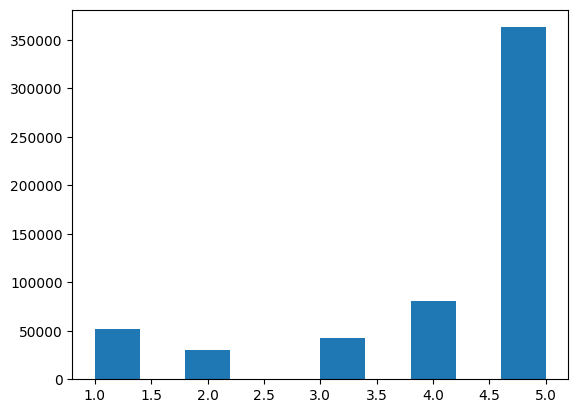

In [5]:
# Show only 1-5 stars
plt.hist(df["Score"])
plt.show()

In view of the distribution of the dataset, I will downsample the dataset to make it a bit more balanced.  
I will reduce the amount of 5-star reviews to 80% of the original amount.

In [6]:
# Find the count of 5-star ratings
count_5_stars = df['Score'].value_counts()[5]

# Calculate the number of 5-star ratings to be downsampled (20% reduction)
downsample_count = int(count_5_stars * 0.2)

# Downsample 5-star ratings by randomly selecting the specified number
df_downsampled = pd.concat([
    df[df['Score'] == 5].sample(n=count_5_stars - downsample_count, random_state=42),
    df[df['Score'] != 5]
])

# Shuffle the downsampled DataFrame
df_downsampled = df_downsampled.sample(frac=1, random_state=42)

# Reduce the DataFrame to the relevant columns
df_downsampled = df_downsampled[['Text', 'Score']]

# Remove duplicate columns
df_downsampled = df_downsampled.drop_duplicates()

# Remove missing values in score and text
df_downsampled = df_downsampled.dropna(subset=['Score', 'Text'])

# Reduce dataframe in size to 30,000 rows
df_downsampled = df_downsampled.sample(n=30000, random_state=42)

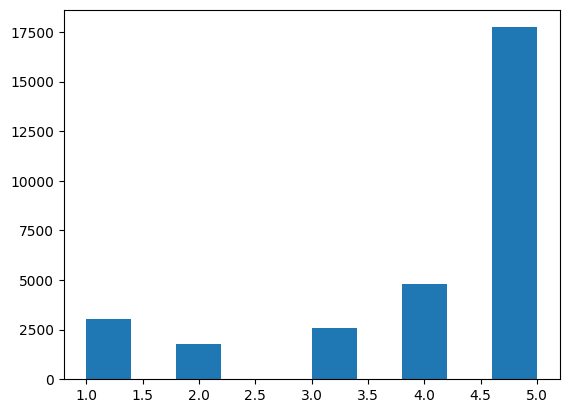

In [7]:
plt.hist(df_downsampled["Score"])
plt.show()

# Data preprocessing

- Remove URLS and email addresses
- Remove punctuation
- Lowercase all words
- Remove stopwords
- Lemmatize words
- Transform texto to numeric tensor

In [8]:
# Remove URLS and email addresses
df_downsampled['Text'] = df_downsampled['Text'].str.replace(r'http\S+|www.\S+|(\@\w+)', '', case=False, regex=True)

# Remove punctuation signs
df_downsampled['Text'] = df_downsampled['Text'].str.replace(r'[^\w\s]', ' ', regex=True)

# Remove numbers
df_downsampled['Text'] = df_downsampled['Text'].str.replace(r'\d+', '', regex=True)

# Remove <br /> tags
df_downsampled['Text'] = df_downsampled['Text'].str.replace('<br />', ' ')

# Lowercase the text
df_downsampled['Text'] = df_downsampled['Text'].str.lower()


In [9]:
df_downsampled.head()

,Text,Score
236844,a wonderful item that reminds me of visits to ...,5
311855,i ordered these along with sour patch watermel...,5
160805,this gum starts off okay enough but as most ...,1
304997,we love this cereal it s the best it s jus...,4
386145,the gumball order took long to arrive and bags...,1


In [10]:
# Remove stopwords
stop = nltk.corpus.stopwords.words('english')
lemmatized_text = df_downsampled['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Lemmatizing
# Not absolutely necessary for this use case
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatized_text = lemmatized_text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

For comparison, we can take a look at an example of a review before and after preprocessing.

In [11]:
review = df_downsampled["Text"][236844]
review_preprocessed = lemmatized_text[236844]
print("Raw review: \n", review)
print("Preprocessed review: \n", review_preprocessed)


Raw review: 
 a wonderful item that reminds me of visits to england as a child and tea time  br   i will be ordering again from this seller as shipping was very fast and the product arrived in great shape  br   thank you for bringing back some great memories 
Preprocessed review: 
 wonderful item reminds visit england child tea time br ordering seller shipping fast product arrived great shape br thank bringing back great memory


### Scores


In [12]:
# Map scores to 0 and 1
# Decided to map 1,2,3 to 0 and 4,5 to 1
# So, now we have a binary classification problem; 0 for negative sentiment and 1 for positive
y = df_downsampled["Score"].map({1:0, 2:0, 3:0, 4:1, 5:1})

y = y.values

### Tokenize the text

In [13]:
tokenized_text = [word_tokenize(i) for i in lemmatized_text]

### Word embeddings


In [14]:
# This model was previously trained with this dataset and saved in a binary file for efficiency
# I trained it with 128 dimensions for each word vector

model = KeyedVectors.load_word2vec_format('model2.bin', binary=True)

In [15]:
# Create the sequences

def create_sequences(tokenized_text, model, vector_size):
    sequences = []
    for seq in tokenized_text:
        seq_vectors = []
        for token in seq:
            if token in model.key_to_index:
                seq_vectors.append(model.get_vector(token))
            else:
                seq_vectors.append(np.zeros((vector_size,)))
        sequences.append(seq_vectors)

    return sequences

sequences = create_sequences(tokenized_text, model, 128)

In [16]:
sequences[0]

[array([-0.0262562 , -0.7051635 ,  0.18625261,  0.03810742,  0.16011423,
         0.02937722, -0.14793536, -0.46817648,  0.05920103,  0.0769574 ,
         0.42557016,  0.18197642,  0.09364887, -0.1922128 ,  0.10657013,
         0.19497508,  0.0563541 ,  0.21434885, -0.61087054,  0.5194539 ,
         0.02877023,  0.06976334,  0.08757082, -0.45474175, -0.2388586 ,
         0.42157632, -0.22784494,  0.42166942,  0.13945247, -0.37426886,
        -0.08752028,  0.25156614, -0.31768557,  0.05409638,  0.2899589 ,
         0.02787333,  0.39396802, -0.09432378,  0.20381378,  0.31014377,
        -0.3223235 ,  0.14306016, -0.22734244, -0.20761827,  0.17858614,
        -0.24886855,  0.07956356, -0.18050067, -0.14477593,  0.20639455,
         0.14624217, -0.19120952, -0.27405104,  0.5363087 , -0.22423647,
         0.06128227,  0.63966435, -0.13466477, -0.53654146, -0.02374347,
        -0.37216744, -0.03899868,  0.09241808,  0.12837192,  0.9044429 ,
         0.51011604,  0.17293324,  0.243841  , -0.1

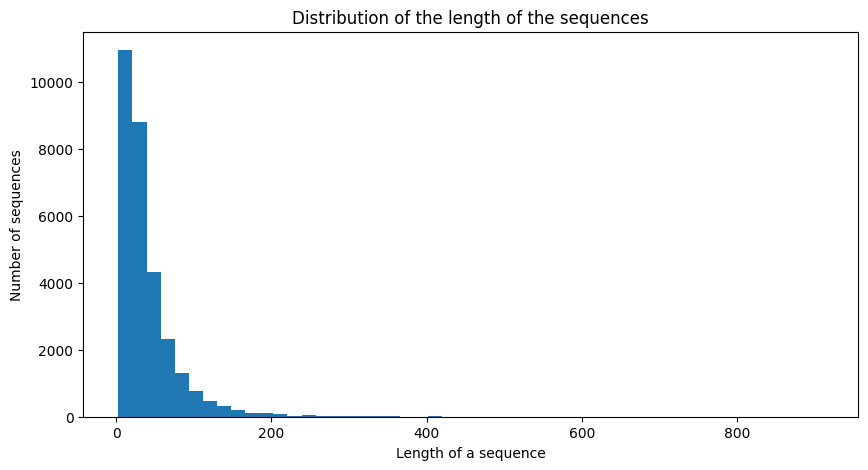

In [17]:
# Distribution of the length of the sequences

plt.figure(figsize=(10, 5))
plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel('Length of a sequence')
plt.ylabel('Number of sequences')
plt.title('Distribution of the length of the sequences')
plt.show()


In [18]:
sequences[0]

[array([-0.0262562 , -0.7051635 ,  0.18625261,  0.03810742,  0.16011423,
         0.02937722, -0.14793536, -0.46817648,  0.05920103,  0.0769574 ,
         0.42557016,  0.18197642,  0.09364887, -0.1922128 ,  0.10657013,
         0.19497508,  0.0563541 ,  0.21434885, -0.61087054,  0.5194539 ,
         0.02877023,  0.06976334,  0.08757082, -0.45474175, -0.2388586 ,
         0.42157632, -0.22784494,  0.42166942,  0.13945247, -0.37426886,
        -0.08752028,  0.25156614, -0.31768557,  0.05409638,  0.2899589 ,
         0.02787333,  0.39396802, -0.09432378,  0.20381378,  0.31014377,
        -0.3223235 ,  0.14306016, -0.22734244, -0.20761827,  0.17858614,
        -0.24886855,  0.07956356, -0.18050067, -0.14477593,  0.20639455,
         0.14624217, -0.19120952, -0.27405104,  0.5363087 , -0.22423647,
         0.06128227,  0.63966435, -0.13466477, -0.53654146, -0.02374347,
        -0.37216744, -0.03899868,  0.09241808,  0.12837192,  0.9044429 ,
         0.51011604,  0.17293324,  0.243841  , -0.1

### Padding the sequences


In [19]:
sequences_padded = pad_sequences(sequences, maxlen=80, padding='post', truncating='post', dtype='float32')

In [20]:
sequences_array = np.array(sequences_padded)
sequences_array.shape

(30000, 80, 128)

# Data split

In [21]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(sequences_array, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [22]:
# Print shapes to check
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)



X_train shape:  (24000, 80, 128)
X_val shape:  (3000, 80, 128)
X_test shape:  (3000, 80, 128)
y_train shape:  (24000,)
y_val shape:  (3000,)
y_test shape:  (3000,)


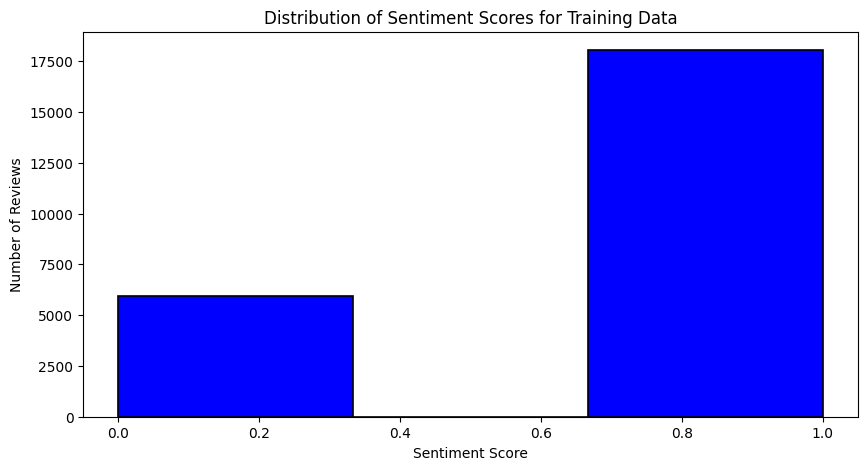

In [23]:
# Analyze distribution of sentiment scores for each of the 3 datasets
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=3, color='blue', edgecolor='black', linewidth=1.2)
plt.title('Distribution of Sentiment Scores for Training Data')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Reviews')
plt.show()

There are around 2k negative reviews and around 6k positive reviews in the training dataset.

In [24]:
rnn = Sequential()
rnn.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
rnn.add(Dropout(0.5))
rnn.add(LSTM(64, return_sequences=False))
rnn.add(Dropout(0.5))
rnn.add(Dense(1, activation='sigmoid'))

rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


2023-07-30 18:36:13.570191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-30 18:36:13.825835: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [25]:
rnn.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20


2023-07-30 18:36:14.435834: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.


750/750 [==============================] - 43s 54ms/step - loss: 0.5657 - accuracy: 0.7505 - val_loss: 0.5427 - val_accuracy: 0.7590
Epoch 2/20
750/750 [==============================] - 39s 52ms/step - loss: 0.5429 - accuracy: 0.7507 - val_loss: 0.5485 - val_accuracy: 0.7590
Epoch 3/20
 85/750 [==>...........................] - ETA: 33s - loss: 0.5753 - accuracy: 0.7360

## Predictions

In [ ]:
predictions = rnn.predict(X_test)

# Round predictions
y_pred = np.zeros(len(predictions))
for i in range(len(predictions)):
    if predictions[i] > 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

# Print the precision and recall, among other metrics
print(classification_report(y_test, y_pred, digits=3))

# Print the overall accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred))

32/32 [==============================] - 1s 24ms/step
[[ 75 174]
 [ 35 716]]
              precision    recall  f1-score   support

           0      0.682     0.301     0.418       249
           1      0.804     0.953     0.873       751

    accuracy                          0.791      1000
   macro avg      0.743     0.627     0.645      1000
weighted avg      0.774     0.791     0.759      1000

Accuracy:  0.791
